#### подгружаем библиотеки

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

import re
import pymorphy2
from collections import Counter
from wordcloud import WordCloud
from tqdm import tqdm

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CptCu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### принимаем датасет

In [24]:
fake_news = pd.read_table(r"C:/Users/CptCu/Desktop/dataset/train.tsv")
fake_news.head()

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1


#### смотрим информацию, строим график распределения ложных и истинных новостей 

In [25]:
fake_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    5758 non-null   object
 1   is_fake  5758 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.1+ KB


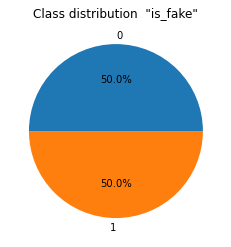

In [26]:
fake_news['is_fake'].value_counts().plot(kind='pie', title='Class distribution  "is_fake"', autopct='%1.1f%%')
plt.axis('off')
plt.show()

#### функции для чистки текста и разбития на токены

In [27]:
TOKEN_RE = re.compile(r'[а-яё]+')
russian_stopwords = stopwords.words("russian")
lemmatizer = pymorphy2.MorphAnalyzer()

def tokenize_text(txt, min_lenght_token=2):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [token for token in all_tokens if len(token) >= min_lenght_token]

def remove_stopwords(tokens):
    return list(filter(lambda token: token not in russian_stopwords, tokens))

def lemmatizing(tokens):
    return [lemmatizer.parse(token)[0].normal_form for token in tokens]

def text_cleaning(txt):
    tokens = tokenize_text(txt)
    tokens  = lemmatizing(tokens)
    tokens = remove_stopwords(tokens)
    return ' '.join(tokens)

#### переписываю изначальный датасет как набор токенов (ключей)

In [28]:
tqdm.pandas()

df_token = fake_news.copy()
df_token['title'] = df_token['title'].progress_apply(text_cleaning)
df_token.head()

100%|█████████████████████████████████████████████████████████████████████████████| 5758/5758 [00:07<00:00, 721.96it/s]


,title,is_fake
0,москвич владимир клутина прийти счёт вмешатель...,1
1,агент кокорин назвать езда встречка житейский ...,0
2,госдума рассмотреть возможность введение секре...,1
3,фас заблокировать поставка скоростной трамвай ...,0
4,против навальный завести дело недоносительство...,1


#### проверяю, что нет "пустых" заголовков

In [29]:
df = df_token.copy()
empty = df[df['title'] == '']
print('Number of empty texts: ', len(empty))
df = df.drop(empty.index)

Number of empty texts:  0


#### ищу повторяюшиеся заголовки, удаляю их

In [30]:
print('Number of duplicates:', df.duplicated().sum())

Number of duplicates: 1


In [31]:
df = df.drop_duplicates()

In [32]:
print('Number of duplicate titles: ', df['title'].duplicated().sum())

Number of duplicate titles:  0


#### смотрю на обработанный текст, с которым уже можно работать

In [33]:
clean_text = df.copy()
clean_text.head(10)

,title,is_fake
0,москвич владимир клутина прийти счёт вмешатель...,1
1,агент кокорин назвать езда встречка житейский ...,0
2,госдума рассмотреть возможность введение секре...,1
3,фас заблокировать поставка скоростной трамвай ...,0
4,против навальный завести дело недоносительство...,1
5,российский студент запретить учиться рубеж,1
6,путин писать книга история украина,1
7,россиянин обхитрить рост цена,0
8,звезда воронин раскрыть подробность свой состо...,0
9,объявить дата выход очко дополнить реальность,0


#### считаю какие слова попадаются в заголовках максимально часто

In [34]:
corpus = clean_text['title'].values

text = ' '.join(corpus)
counter = Counter(text.split())
sorted_counter = counter.most_common()
sorted_counter[:5]

[('россия', 536),
 ('российский', 287),
 ('год', 242),
 ('новый', 220),
 ('москва', 158)]

#### график распределения, как часто встречаются слова

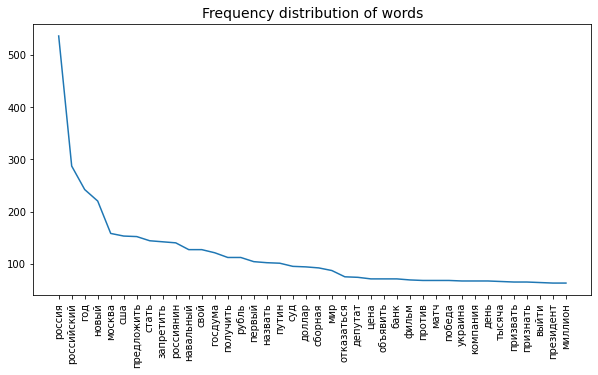

In [35]:
words = [pair[0] for pair in sorted_counter]
words_count = [pair[1] for pair in sorted_counter]

plt.figure(figsize=(10, 5))
plt.plot(words[:40], words_count[:40])
plt.xticks(rotation=90)
plt.title('Frequency distribution of words', fontsize=14)
plt.show()

#### какие слова попадаются чаще всего в фэйковых заголовках

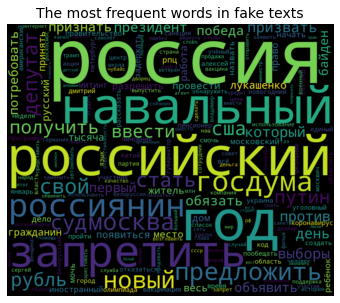

In [36]:
only_fake = clean_text[clean_text['is_fake'] == 1]
text_fake = ' '.join(only_fake['title'].values)

wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text_fake)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('The most frequent words in fake texts', fontsize=14)
plt.show()

#### какие слова попадаются чаще всего в истинных новостях

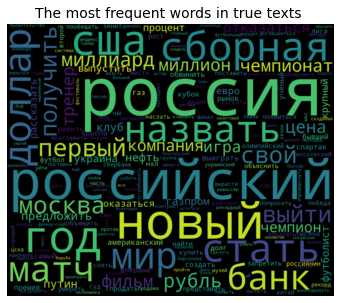

In [37]:
nofake = clean_text[clean_text['is_fake'] == 0]
norm_text = ' '.join(nofake['title'].values)

wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(norm_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('The most frequent words in true texts ', fontsize=14)
plt.show()

#### разбиение учебной выборки

In [38]:
df_train, df_test =  train_test_split(clean_text, test_size=0.1, random_state=42)

#### передаю значения и ключи для train-test-a

In [39]:
train_corpus = df_train['title'].values
test_corpus = df_test['title'].values

y_train = df_train['is_fake']
y_test = df_test['is_fake']

#### токены в векторы

In [40]:
vectorizer = TfidfVectorizer(ngram_range=(2,4), analyzer='char_wb', max_df=0.8, min_df=10)
X_train = vectorizer.fit_transform(train_corpus)
X_test = vectorizer.transform(test_corpus)

print('Total features: ', len(vectorizer.get_feature_names()))

Total features:  8359


#### обрабатываю логистической регрессией

In [41]:
Logregres = LogisticRegression(max_iter=10000, C=3, solver='liblinear')
Logregres.fit(X_train, y_train)
y_pred = Logregres.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85       296
           1       0.84      0.83      0.84       280

    accuracy                           0.84       576
   macro avg       0.84      0.84      0.84       576
weighted avg       0.84      0.84      0.84       576



#### пара графиков визуализации результатов

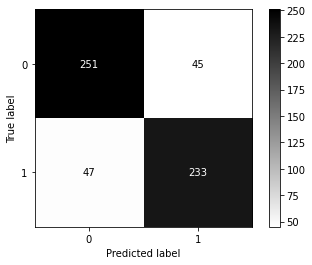

In [42]:
plot_confusion_matrix(Logregres, X_test, y_test, cmap='binary')
plt.show()

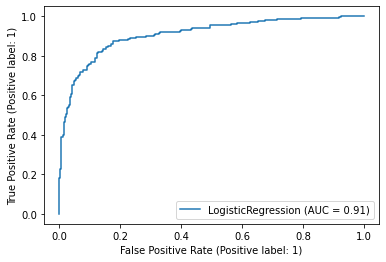

In [43]:
plot_roc_curve(Logregres, X_test, y_test)
plt.show()

#### принимаю второй датасет

In [44]:
test = pd.read_table(r"C:/Users/CptCu/Desktop/dataset/test.tsv")
test.head()

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,0
1,Ночью под Минском на президентской горе Белара...,0
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,0
3,"Сельская церковь, собравшая рекордно низкое ко...",0
4,Акции Google рухнули после объявления о переза...,0


#### токенезирую новый текст

In [45]:
TOKEN_RE = re.compile(r'[а-яё]+')
russian_stopwords = stopwords.words("russian")
lemmatizer = pymorphy2.MorphAnalyzer()

def tokenize_text(txt, min_lenght_token=2):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [token for token in all_tokens if len(token) >= min_lenght_token]

def remove_stopwords(tokens):
    return list(filter(lambda token: token not in russian_stopwords, tokens))

def lemmatizing(tokens):
    return [lemmatizer.parse(token)[0].normal_form for token in tokens]

def text_cleaning(txt):
    tokens = tokenize_text(txt)
    tokens  = lemmatizing(tokens)
    tokens = remove_stopwords(tokens)
    return ' '.join(tokens)

In [46]:
tqdm.pandas()

df_token_test = test.copy()
df_token_test['title'] = df_token_test['title'].progress_apply(text_cleaning)
df_token_test.head()

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 748.99it/s]


,title,is_fake
0,роскомнадзор представить реестр сочетание цвет...,0
1,ночью минский президентский гора беларашмор пи...,0
2,бывший спичрайтер юрий лоза рассказать труднос...,0
3,сельский церковь собрать рекордно низкий колич...,0
4,акция рухнуть объявление перезапуск,0


#### смотрю результат очистки-токенезации

In [50]:
clean_text_test = df_token_test.copy()
clean_text_test.head(10)

,title,is_fake
0,роскомнадзор представить реестр сочетание цвет...,0
1,ночью минский президентский гора беларашмор пи...,0
2,бывший спичрайтер юрий лоза рассказать труднос...,0
3,сельский церковь собрать рекордно низкий колич...,0
4,акция рухнуть объявление перезапуск,0
5,курс доллар вырасти исторический максимум,0
6,опек назвать оптимальный уровень цена нефть,0
7,российский авиакомпания открыть рейс тбилиси урал,0
8,швейцарский горнолыжница расстрелять дом родитель,0
9,учредить театральный премия имя гарольд пинтер,0


#### какие слова встрачаются чаще всего

In [55]:
corpus = clean_text_test['title'].values

text = ' '.join(corpus)
counter = Counter(text.split())
sorted_counter = counter.most_common()
sorted_counter[:5]

[('россия', 123),
 ('российский', 51),
 ('год', 46),
 ('новый', 35),
 ('россиянин', 34)]

In [65]:
train_corpus_test =  clean_text['title'].values
test_corpus_test =  clean_text_test['title'].values

y_train = clean_text['is_fake']
y_test = df_test['is_fake']
#y_test = Logregres.predict(clean_text_test['title'])

In [66]:
vectorizer = TfidfVectorizer(ngram_range=(2,4), analyzer='char_wb', max_df=0.8, min_df=10)
X_train = vectorizer.fit_transform(train_corpus_test)
X_test = vectorizer.transform(test_corpus_test)

In [69]:
Logregres = LogisticRegression(max_iter=10000, C=3, solver='liblinear')
Logregres.fit(X_train, y_train)
y_pred = Logregres.predict(X_test)

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0